$$ Cloud-Architecture

># Importing Files

In [1]:

from feature_extractor import FeatureExtractor
import numpy as np
from PIL import Image
import os
from pathlib import Path
import tkinter as tk 
from tkinter import filedialog 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()
from sklearn.cluster import KMeans
import cv2


># Reading Files 

In [2]:
images = []
database = r"C:\Users\piyus\OneDrive\Documents\Office\21Sep\CBIR\vgg-git\sis\database"
for filename in os.listdir(database):
    img = Image.open(os.path.join(database,filename))
    '''Initializing dictionary '''
    image_info = {
        "image_name": os.path.basename(os.path.join(database,filename)),
        "image_data": img,
        "image_path": os.path.join(database,filename)
    }
    '''checking for image readability'''
    if img is not None:
        images.append(image_info)

>#  Extracting features and saving it to numpy file

In [3]:
fe = FeatureExtractor()

# for img in images:
#     temp = fe.extract(img["image_data"])
#     feature_path = Path("C:/Users/piyus/OneDrive/Documents/Office/21Sep/CBIR/vgg-git/sis/features/") / (img["image_name"] + ".npy")
#     np.save(feature_path,temp)

># Taking reference image as input 

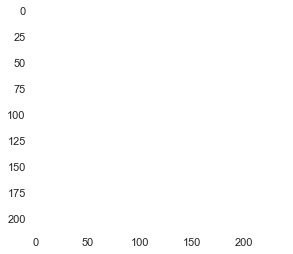

In [4]:
root = tk.Tk() 
root.withdraw() 
file_path = filedialog.askopenfilename() 
refer_image = Image.open(file_path)
# img  = cv2.imread(file_path)
plt.imshow(refer_image)


>## Finding L2 Distance from query image

>reading from saved npy features 

In [5]:
# dists = np.linalg.norm(features-query, axis=1)
features = []
img_paths = []
folder = "C:/Users/piyus/OneDrive/Documents/Office/21Sep/CBIR/vgg-git/sis/features/"
# for feature_path in Path("./features").glob("*.npy"):
#     features.append(np.load(feature_path))
#     img_paths.append(Path("./database") / (feature_path.stem + ".jpg"))
for filename in os.listdir(folder):
    features.append(np.load(Path(folder) / filename))

features = np.array(features)

>## Appending Distance in final list

In [6]:
refer_fe = fe.extract(refer_image)
dists = np.linalg.norm(features-refer_fe, axis=1) 

In [7]:
i = 0
final = {"name" : [],
        "distance": []}
for a in dists:
    final["name"].append(images[i]["image_name"])
    final["distance"].append(a)
    i+=1
# for a in dists:
#     temp = {
#         "name" : images[i]["image_name"],
#         "distance" : a
#     }
#     final.append(temp)
#     i +=1

>## Scatter plot of distances

In [8]:
# plt.scatter(final["name"],final["distance"])

# plt.show()

Converting Data into pandas dataframe 

In [9]:
 df = pd.DataFrame(final)
 x = df.iloc[:,1:3]

>## Initializing K means

># Checking for cluster size

In [10]:
from scipy.cluster.vq import kmeans,vq

centroids,_ = kmeans(x,100)
# assign each sample to a cluster
idx,_ = vq(x,centroids)
#Print number of elements per cluster
print(np.bincount(idx))

[14  4 12  7  9  5 13  7  3 16  5 13  6  7 11  5 12  9  8  2  7  8  7 23
 15 12 10  4  7  4  9 10  9  8  4 11 12 12  7 25  9 14  8 15  9 11 12  4
 12  8  6  7 10 22  9  2 20  9  6  8  2  7 16 11  5 10  8  4  6 10  6  5
  7 10  4 18 11 11  5  6  3  7  8  9  8  9 10 20  9  5 12 11  4  8 12  9
  6  6  9]


In [11]:
k = 100
clusters = KMeans(k,random_state=42)
clusters.fit(x)

KMeans(n_clusters=100, random_state=42)

> #  Appending clusterid in new dataframe

In [12]:
y = pd.DataFrame(x,columns=["distance"])
y["clusterid"] = clusters.labels_

# `Printing new Dataframe`

In [13]:
y

,distance,clusterid
0,1.225922,48
1,1.095258,80
2,1.227573,22
3,1.000222,37
4,1.199311,38
...,...,...
895,1.153000,67
896,1.088352,82
897,1.027572,74
898,1.160021,68


| -------------------------------------------------------------------- | -------------------------------------------------------------------- |

# ``` Predicting new image's cluster id ```

In [14]:
# root = tk.Tk() 
# root.withdraw() 
# file_path = filedialog.askopenfilename() 
# new_image = Image.open(file_path)
# # plt.imshow(img)
# plt.imshow(new_image)

>## Distance of new image from reference image

In [17]:
threshold = 50
# from VideoCapture import Device
# cam = Device(devnum = 0,showVideoWindow=0)
orb = cv2.ORB_create()

In [21]:
cap = cv2.VideoCapture(0)
while True:
    ret,frame = cap.read()
    cv2.imshow("WebCam",frame)
    kp_frame,des_frame = orb.detectAndCompute(frame,None)
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    frame = Image.fromarray(frame)
    frame_fe = fe.extract(frame)
    
    a = [frame_fe]
    frame_distance = np.linalg.norm(a-refer_fe, axis=1)
    x.xs(0)["distance"] = float(frame_distance[0])
    a = clusters.predict(x)
    y_new = y[y['clusterid']==a[0]]
    breakloop = False
    for i in y_new.index.values:
        img = (images[i]['image_data'])
        img = np.array(img)
        img = img[:,:,::-1].copy()
       
        kp,des = orb.detectAndCompute(img,None)
        
        flann_params= dict(algorithm = 6,
                               table_number = 6, 
                               key_size = 12,     
                               multi_probe_level = 2) 
        matcher = cv2.FlannBasedMatcher(flann_params, {})
        good= []
        matches = matcher.knnMatch(des, des_frame, k=2)
        for m,n in matches:
            if m.distance < 0.75 * n.distance:
                good.append(m)
        if(len(good)>threshold):
            breakloop = True
            temp = i
            break;
    if(breakloop):
        plt.imshow(images[temp]['image_data'])
        cap.release()
        cv2.destroyAllWindows()
        break;
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    # temp=y_new
    # temp['d']=abs(temp['distance']-frame_distance[0])
    # index_found = temp.index[temp['d']==temp['d'].min()][0]
    # plt.imshow(images[index_found]['image_data'])
    # img = images[y_new.index.values]['image_data']
    # cv2.imshow("WebCam",frame)
    # if cv2.waitKey(1) & 0xFF == ord('q'):
    #     break
cap.release()
cv2.destroyAllWindows()

ValueError: too many values to unpack (expected 2)

In [193]:
print(y_new.index.values)

100


In [172]:
new_fe = fe.extract(new_image)
a = [new_fe]
dists_new = np.linalg.norm(a-refer_fe, axis=1) 
print(dists_new[0])
x.xs(0)["distance"] = float(dists_new[0])
# x.head(1)
a = clusters.predict(x)
print(a[0])

1.1073898


## Predicting model based on new image's distance from refrence image

In [174]:
y_new = y[y['clusterid']==a[0]]
y_new

,distance,clusterid
100,1.106268,66
126,1.105518,66
176,1.107232,66
182,1.108447,66
265,1.108124,66
443,1.107390,66
474,1.106961,66
495,1.106840,66
596,1.107435,66
632,1.107926,66


>## Computing Distance of new image from other images in its cluster

In [182]:
temp=y_new
temp['d']=abs(temp['distance']-dists_new[0])
temp.index[temp['d']==temp['d'].min()][0]


    

C:\Users\piyus\AppData\Local\Temp/ipykernel_10896/3005077723.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['d']=abs(temp['distance']-dists_new[0])


,distance,clusterid,d
100,1.106268,66,0.001122
126,1.105518,66,0.001872
176,1.107232,66,0.000158
182,1.108447,66,0.001058
265,1.108124,66,0.000734
443,1.107390,66,0.000000
474,1.106961,66,0.000429
495,1.106840,66,0.000549
596,1.107435,66,0.000045
632,1.107926,66,0.000536


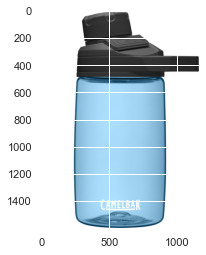

In [181]:
plt.imshow(images[index_found]['image_data'])

> End of file